[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/9_nb_feature_engineering.ipynb) 

# Chapter 9 - Feature engineering and selection

So far, we've gone through some basic feature pre-processing. This was just the tip of the iceberg. This week, we'll further elaborate on feature engineering, which is the art of creating meaningful features from your processed data, and exemplify some standard coding practices. In general, you will likely have to use a combination of domain and statistical knowledge to get the most out of your variables. This includes techniques such as scaling and [transforming](https://machinelearningmastery.com/power-transforms-with-scikit-learn/) (there are [other techniques](https://machinelearningmastery.com/power-transforms-with-scikit-learn/) when dealing with time series data). It could also be the creation of new variables using some kind of combination of the variables that you have.

In this tutorial, we will discuss basic transformations for feature engineering and how to perform feature selection. As you know, your model should include only include *relevant* variables. Any variable that does not raise predictability may cause overfitting and hamper model performance on new data. 

We will end with two useful tricks, importing from scripts and pipelines which should make your code quicker and cleaner to read.


Here are the contents point by point:
- Preliminaries
- Feature engineering
- Object Creation
- Feature selection
- Importing scripts
- Pipelines
- Exercises

# Preliminaries

We will begin as usual, by importing necessary libraries, settings and loading the data. 

In [4]:
# Import standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

# Load credit risk data in pre-processed format from GitHub
#data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_prepared.csv' 
#df = pd.read_csv(data_url)
file = '/Users/aubrey/Documents/GitHub/BADs/data/hmeq_prepared.csv'
df = pd.read_csv(file)


# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_train.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero
3429,18100.0,22203.0,138057.0,DebtCon,Other,8.0,0.0,0.0,356.90906,1.0,10.0,40.874382,True
5767,45000.0,47321.0,115000.0,DebtCon,Other,7.0,0.0,1.0,130.30000,0.0,22.0,34.818260,True
836,8600.0,66366.0,75957.0,DebtCon,ProfExe,8.0,0.0,0.0,72.91672,2.0,25.0,39.660408,True
4436,23000.0,48003.0,64720.0,DebtCon,Office,4.0,0.0,0.0,160.60605,1.0,26.0,33.629925,True
1448,11000.0,21780.0,85505.0,HomeImp,ProfExe,19.0,0.0,0.0,240.68259,0.0,10.0,24.404335,True


In [5]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4768, 13) (1192, 13) (4768, 1) (1192, 1)


# Feature Engineering 

## Data pipeline construction revisited

Here is a sample of how your data preparation process should look. This can however vary depending on the data with which you are working and the goal of your model. In general, you may **at least** want to follow these steps:

**1) Basic cleaning of null values, duplicates and outliers**

These values will have a big impact on how Python runs and how models are calculated. When it comes to NaN values and outliers, there are several approaches to deal with them. You could remove them, replace them with another value (indicator value, mode, mean, max, min, etc), use a mini-model to impute them among other options. This has been done for the most part in this data set already. See [Tutorial #4](https://github.com/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb) for details.

**2) Encode variables in the most appropriate way**

Check your dataframe using the method `.info()` . Are your continuous variables encoded as integers or floats? If they are type `object` then the column may need to be checked again for null values. It is good practice to change any categorical variables to the `category` data type as it increases processing time. Once you have confirmed that you will finalize the model with a categorical variable, it can be good to use one-hot encoding as described in step 5.

**3) Ensure variables fit statistical assumptions/model requirements**

The next steps are a bit more complex and will depend on which model you need to use. Your goal is to make sure your data will be accurately processed by your model. Note that a lot of statistical assumptions depend on normal distribution and scaling. For example, models like K-Means and other distance-based methods are very sensitive to the magnitude of variable values.  We will first examine ways to do that.

In this step, you may also want to remove features which are highly correlated to one another.

**4) Filter out variables with low predictive power**

You may now want to examine whether the variables contribute to your model. We will discuss filter methods to do just that. Note that some variables may only be effective in combination with others, so be careful with this step. Recall that wrapper methods for feature selection are more powerful but also more costly.  

**5) One-hot encode categorical variables**

Once you have decided to keep a categorical feature, it can be useful to one-hot encode the feature. Again, one-hot encoding means that instead of one categorical column, you have multiple dummies, which represent possible category values. For example, if your categorical variable "transport" had the possible values of "car", "by foot" or "bus", you would split it into columns called "transport_car" and "transport_bus". "by foot" is indicated if neither of those have a value of 1 for that observation. In this tutorial, we will also learn about an alternative way to deal with categorical features using a weight-of-evidence (WoE) transformation.

**6) Double check the model only includes appropriate variables**

Next, you may want to try a wrapper method or step-wise regression as another check to ensure you are only including relevant variables.

In many cases, you may have to repeat some of these steps several times. Remember the idea of **garbage in, garbage out**. If you feed a model nonsense, expect nonsense to come right back out. This is likely what will take the most of your time as a data scientist.

In [6]:
# Let's get a quick overview of the data types of each column and make sure they are correct

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BAD        5960 non-null   bool   
 1   LOAN       5960 non-null   float64
 2   MORTDUE    5960 non-null   float64
 3   VALUE      5960 non-null   float64
 4   REASON     5960 non-null   object 
 5   JOB        5960 non-null   object 
 6   YOJ        5960 non-null   float64
 7   DEROG      5960 non-null   float64
 8   DELINQ     5960 non-null   float64
 9   CLAGE      5960 non-null   float64
 10  NINQ       5960 non-null   float64
 11  CLNO       5960 non-null   float64
 12  DEBTINC    5960 non-null   float64
 13  DEROGzero  5960 non-null   bool   
dtypes: bool(2), float64(10), object(2)
memory usage: 570.5+ KB


Luckily, most of our variables are actually encoded the right way! Let's just change the two categorical variables to a categorical type. Note that this is not a data type in `NumPy`, only in `Pandas`. As such, you may run into problems if the data type becomes relevant in a `NumPy` calculation. Just keep that in mind!

In [7]:
# Let's change our two categorical variables to the correct type for our interim analysis

df['REASON'] = df['REASON'].astype('category')
df['JOB'] = df['JOB'].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BAD        5960 non-null   bool    
 1   LOAN       5960 non-null   float64 
 2   MORTDUE    5960 non-null   float64 
 3   VALUE      5960 non-null   float64 
 4   REASON     5960 non-null   category
 5   JOB        5960 non-null   category
 6   YOJ        5960 non-null   float64 
 7   DEROG      5960 non-null   float64 
 8   DELINQ     5960 non-null   float64 
 9   CLAGE      5960 non-null   float64 
 10  NINQ       5960 non-null   float64 
 11  CLNO       5960 non-null   float64 
 12  DEBTINC    5960 non-null   float64 
 13  DEROGzero  5960 non-null   bool    
dtypes: bool(2), category(2), float64(10)
memory usage: 489.3 KB


## Scaling

Features will likely have arbitrary magnitudes. For example, a customer's spending range from 0 to 50,000 but a dummy variable about them may only take the value 0 or 1. For many algorithms, like the distance function in kMeans, this is problematic. The distance function will try to minimize differences among features using their raw values. This means that kMeans will focus on variables with arbitrarily high values like spending when that may not be as important as a dummy. One way to deal with this is to scale features so that their values are in a controlled range; without altering the distribution of feature values. This way, all features will be considered equally in distance calculations. 

There are two major ways to scale: standardization and min-max scaling (also known as normalization).

### Standardization
After standardization, your feature will now be distributed around a mean  feature value of zero with standard deviation equal to one.

$$ X_{new} = \frac{X-\mu}{\sigma} $$

There is no controlled or a priori set maximum or minimum value here. This means that standardization does not deal with outliers. You may have a clearer picture of how extreme these outliers are after standardization.

### Min-Max Scaling
After min-max scaling, your variables will have a range of 0 and 1. Minimum feature values will become 0 and maximum values will be 1.

$$ X_{new} = \frac{X-X_{min}}{X_{max}-X_{min}} $$

**NOTE** This type of scaling is sometimes called normalization but you should note that it simply compacts the values of the features to be between 0 and 1, it does not change the overall shape of the data.


In [9]:
# Standardization
def standardize(var):
    return (var - np.mean(var)) / np.std(var)


# Min-max scaling
def min_max_scale(var):
    return (var - min(var)) / (max(var) - min(var))

Let's first look at how this variable looks before and after normalization and standardization using a box plot and then a histogram. **Note the scaling of the y-axes in all of all the following plots.**

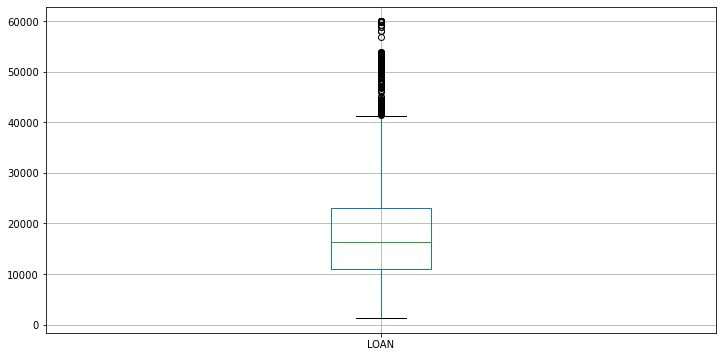

In [10]:
# Raw variable 
X_train[['LOAN']].boxplot();

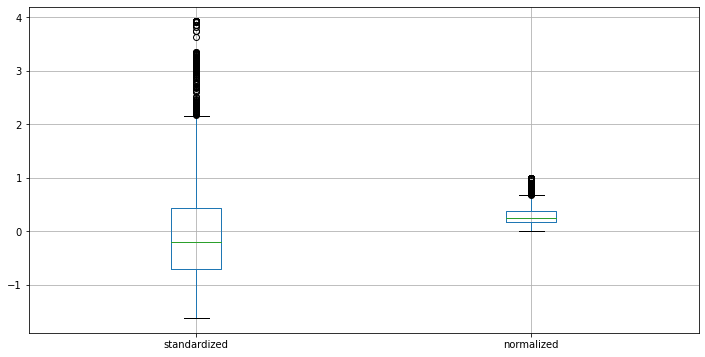

In [11]:
# Comparison of the normalized vs. standardized variable (check axes for size)

loan_standardized = standardize(X_train['LOAN'])

loan_normalized = min_max_scale(X_train['LOAN'])

loans_scaled = pd.DataFrame({"standardized": loan_standardized, "normalized": loan_normalized})

loans_scaled.boxplot();

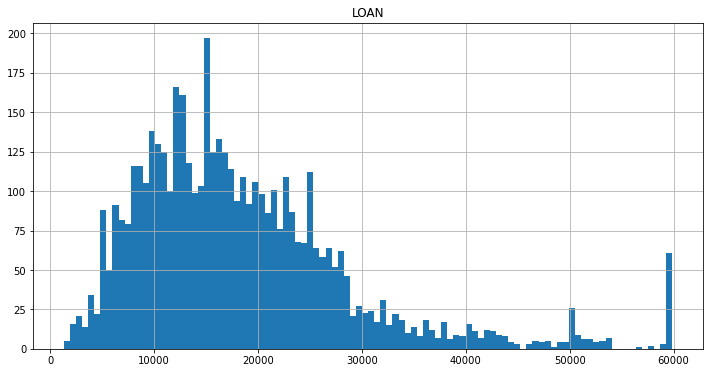

In [12]:
# Histogram of raw variable

X_train[['LOAN']].hist(bins=100);

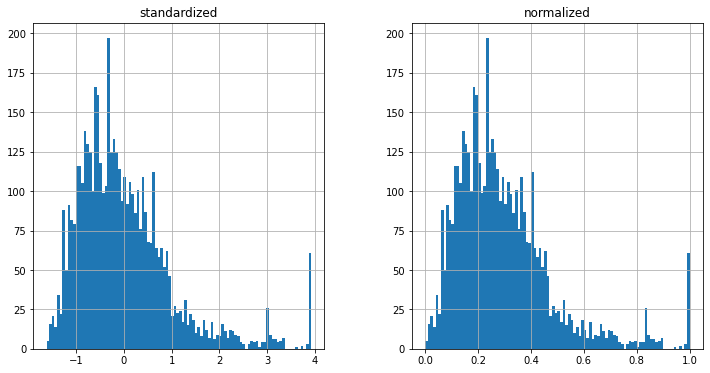

In [13]:
# Comparison of the normalized vs. standardized variable (check axes for size)

loans_scaled.hist(bins=100);

Now we can see the big difference between the two types of scaling. With min-max scaling, we have the variable ranging between 0 and 1. With standard scaling, we have the variable showing us its position relative to standard deviations. Note that in both of these examples, the variable was squeezed into a smaller range but did not change shape overall. There are ways to change its shape, which we will explore next. 

First, let's just quickly look at the standard way to perform scaling when using `sklearn`. We can just use the `MinMaxScaler()` and `StandardScaler` to do what our custom functions did. In practice, we would rely on these routines and avoid coding our own customer functions.

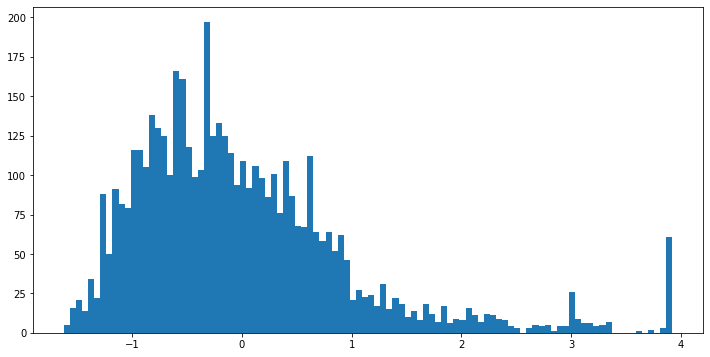

In [14]:
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
standardscaled = standardscaler.fit_transform(X_train[['LOAN']])
_ = plt.hist(standardscaled, bins=100)
plt.show()

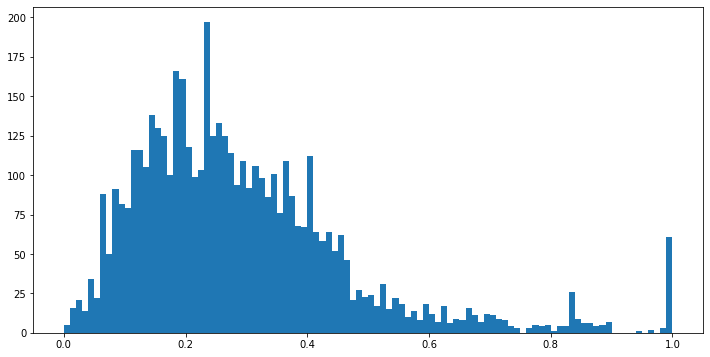

In [15]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
minmaxscaled = minmaxscaler.fit_transform(X_train[['LOAN']])

_ = plt.hist(minmaxscaled, bins=100)
plt.show()

It is good practice to scale variables before putting them into an algorithm. Note that some algorithms (eg. tree algorithms) don't necessarily require this. Since we will be using a logistic regression initially, we will scale these variables using standard scaling later.

## Checking features for normality

Normality is a critical condition for many statistical tests and the creation of confidence intervals. If this is the goal of your work, you will likely need to find some way to normalize your variables. Further, some methods for descriptive, explanatory or predictive modeling may benefit from normality. Imagine, for example, a dependent variable that displays a complex, non-normal distribution. If the distribution of the dependent is non-normal, it is likely that residuals will also be non-normal, which vialoates an assumption of the linear model. Long story short, many importand data science methods may benefit from feature transformations that change the distribution of a feature such that it becomes more normal. Here we will introduce 3 useful transformations to achieve this: log, Box-Cox and Yeo-Johnson transformations.

There are several ways to check which variables could benefit from such a transformation. One method would be to create a histogram of each variable and check its shape. Remember that you are looking for a perfect bell shape with even tails on either side. As you can imagine, this does not happen very often with many variables.

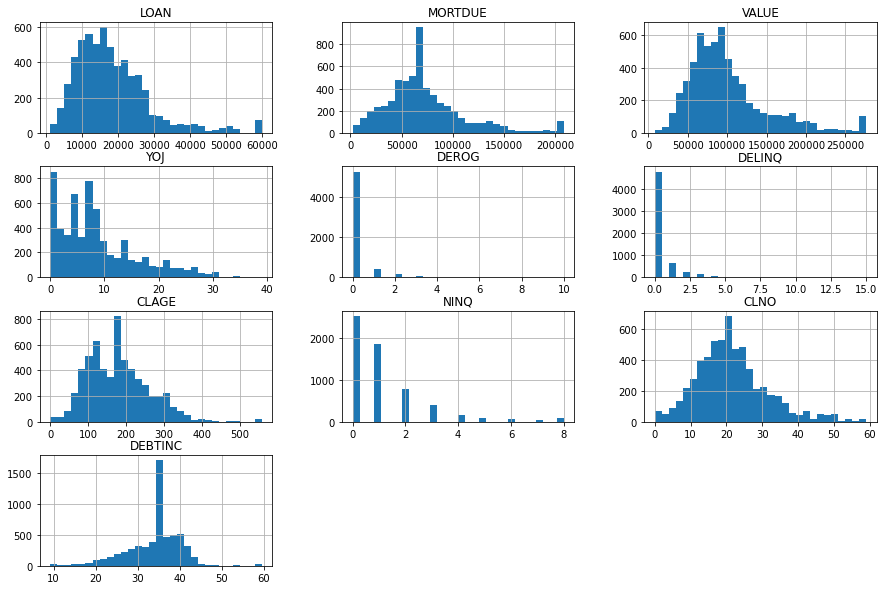

In [16]:
df.select_dtypes(include='float64').hist(bins=30, figsize=(15, 10));

In [17]:
# Choose a feature of interest and we'll take a deep dive into it
# DEROG, DELINQ and NINQ are bad candidates as they resemble categorical variables

feature = df['LOAN'] 

If you would like a more scienfitic test for normality, you can use `normaltest` from `scipy`. This function's documentation is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html). It outputs 2 numbers, the first is the sum of squares of the z-scores returned by a skewtest and kurtosistest. The second is a 2-sided chi2 probability hypothesis test. Thus, if the p-value is below 0.05, it is likely you do not have normally distributed data.

In [18]:
from scipy import stats

stats.normaltest(feature)

NormaltestResult(statistic=1603.6531776769357, pvalue=0.0)

We can see problems a bit more clearly with a quantile-quantile (QQ) plot. Ideally, the blue line should match the red line (quantiles of a feature versus the quantiles/ppf of a distribution). If not, it is less likely that it comes from a normal distribution.

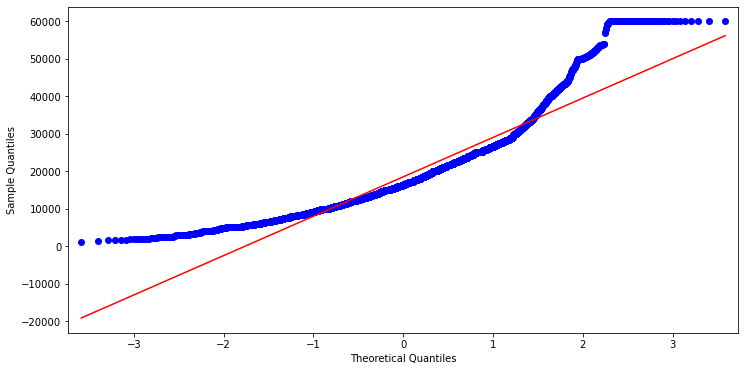

In [19]:
from statsmodels.graphics.gofplots import qqplot

qqplot(feature, line='s')
plt.show()

Just to reiterate that it is a bit misleading to say min-max scaling is "normalization", let's min-max scale our feature and perform the test. As we can see, `normaltest` outputs the same test statistic and pvalue.

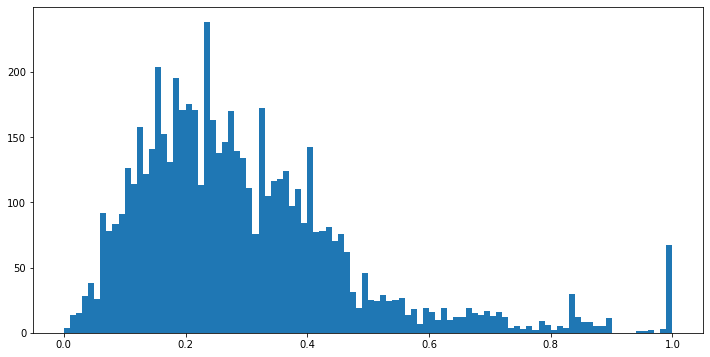

In [20]:
minmaxscaled_feature = minmaxscaler.fit_transform(pd.DataFrame(feature))

_ = plt.hist(minmaxscaled_feature, bins=100)
plt.show()

In [21]:
stats.normaltest(minmaxscaled_feature)

NormaltestResult(statistic=array([1603.65317768]), pvalue=array([0.]))

As such, if you need your variable to have more of a normal distribution, it's going to take more than min-max scaling.

## Common feature transformations for numeric data

### Log Transformation
One major use of logs is to create linearity from exponential relationships. This can help algorithms (e.g., linear models) capture the fit of many variables. Remember that logs take only strictly positive variables. If you have any negative values, you will have to rescale your data, remove them or find another way to deal with them.

$ x^{(t)} = g(x) = log(x) $



### Box Cox Transformation
If your variable has a skewed tail, this can be problematic for the assumption on normality. You can try to correct this with a Box Cox transformation. This only works with strictly positive values (greater than 0). You can always rescale variables so they meet this criteria before putting them into this formula.

$
    x^{(t)} = g(x; \lambda) =
    \begin{cases}
      \frac{x^\lambda - 1}{\lambda}, & \text{if}\ \lambda \neq 0 \\
      log(x), & \text{otherwise}
    \end{cases}
$



### Yeo-Johnson Transformation
This formula is essentially a more elaborate version of Box Cox. It can take any numbers (0 and under is completely fine). 

$
    x^{(t)} = g(x; \lambda) =
    \begin{cases}
      \frac{(1+x)^\lambda - 1}{\lambda}, & \text{if}\ \lambda \neq 0 \ \text{and}\ x \geq 0 \\
      log(x+1), & \text{if}\ \lambda = 0 \ \text{and}\ x \geq 0 \\
      -\frac{(1-x)^{2-\lambda} - 1}{2-\lambda}, & \text{if}\ \lambda \neq 2 \ \text{and}\ x < 0\\
      -log(-x+1), & \text{if}\ \lambda = 2 \ \text{and}\ x < 0\\
    \end{cases}
$


## Testing transformations
Let's look at a version of these which we have created from scratch and check what they do to our variable using histograms and box plots.

In [19]:
def box_cox_transform(var, power=0):

    try:
        assert (var > 0).all()  # Function only defined > 0
    except AssertionError:
        raise ValueError("Variable values must be strictly positive")

    # Special case lambda=0
    if power == 0:
        var = np.log(var)

    else:
        var = (var ** power - 1) / power

    return var

In [20]:
def yeo_johnson_transform(var, power=1):

    var_mod = np.empty_like(var)

    # Special case lambda=0
    if power == 0:
        mask = (var >= 0)
        var_mod[mask] = np.log(var[mask] + 1)
        var_mod[~mask] = -((-var[~mask] + 1)**2 - 1) / 2 

  # Special case lambda=2
    elif power == 2:
        mask = (var >= 0)
        var_mod[mask] = ((var[mask] + 1)**2 - 1) / 2
        var_mod[~mask] = -np.log(-var[~mask] + 1)

    else:
        mask = (var >= 0)
        var_mod[mask] = ((var[mask] + 1)**power - 1) / power
        var_mod[~mask] = -((-var[~mask] + 1)**(2 - power) - 1) / (2 - power)

    return pd.Series(var_mod)

Now let's check the histogram of the regular feature of interest and its modified versions. Pay attention to the scale. What happens as the power of the BC and YJ transformation increases? What happens to the shape of the histogram?

In [21]:
# Adjust coefficient of Box Cox transformation on the feature to show plot below

bc1 = box_cox_transform(feature+1, power=0)  # Adding 1 as all features start at 0, not allowed in BC
bc2 = box_cox_transform(feature+1, power=.5)
bc3 = box_cox_transform(feature+1, power=1)

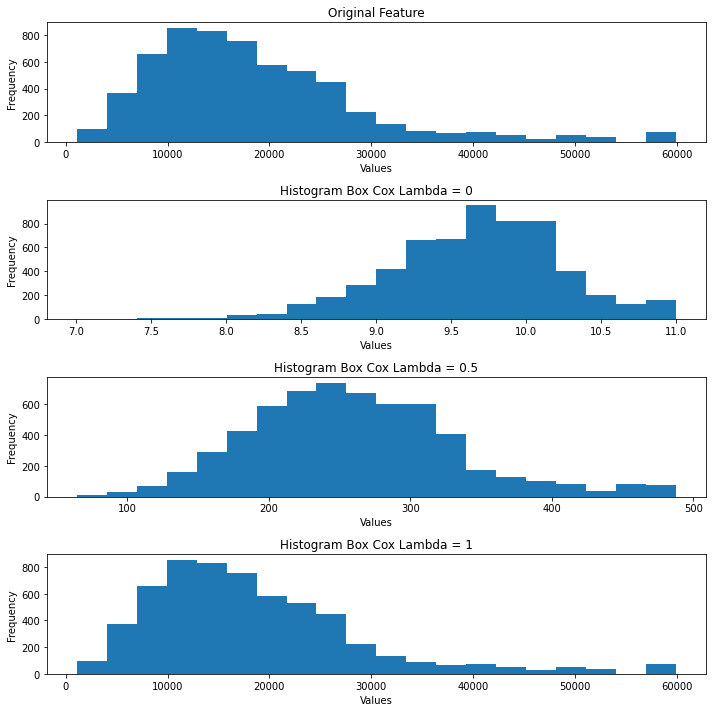

In [22]:
# Plot a histogram per coefficient of BC transformation

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.hist(feature, bins=20)
ax2.hist(bc1, bins=20)
ax3.hist(bc2, bins=20)
ax4.hist(bc3, bins=20)

ax1.set_title('Original Feature')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Values')

ax2.set_title('Histogram Box Cox Lambda = 0')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Values')


ax3.set_title('Histogram Box Cox Lambda = 0.5')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Values')


ax4.set_title('Histogram Box Cox Lambda = 1')
ax4.set_xlabel('Values')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Did you notice that the peak of the data moves? We are looking for a sweet spot where the peak is somewhere directly between the two tails so the distribution is almost perfectly bell-shaped. Note that the scale also changes pretty dramatically too. Make sure that you scale this variable after if necessary to make sure it fits your model requirements!

Now let's check Yeo-Johnson.

In [23]:
# Adjust coefficient of YJ transformation on the feature to show plot below

yj1 = yeo_johnson_transform(feature, power=0)
yj2 = yeo_johnson_transform(feature, power=.5)
yj3 = yeo_johnson_transform(feature, power=1)

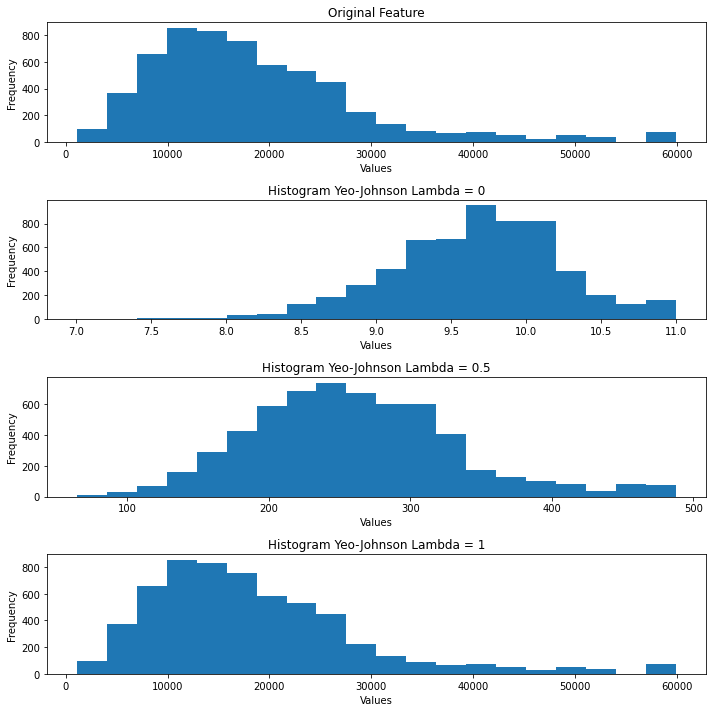

In [24]:
# Plot a histogram per coefficient of YJ transformation

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)


ax1.hist(feature, bins=20)
ax2.hist(yj1, bins=20)
ax3.hist(yj2, bins=20)
ax4.hist(yj3, bins=20)

ax1.set_title('Original Feature')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Values')


ax2.set_title('Histogram Yeo-Johnson Lambda = 0')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Values')


ax3.set_title('Histogram Yeo-Johnson Lambda = 0.5')
ax3.set_xlabel('Values')
ax3.set_ylabel('Frequency')

ax4.set_title('Histogram Yeo-Johnson Lambda = 1')
ax4.set_xlabel('Values')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

We see that it does the same type of thing. The peak of the data is shifted and again, we are trying to find the coefficient which will give us the most bell-curve-like shape.

There are a few ways we can find the optimal coefficient. This is a task in the exercises to do manually. However, `scipy` actually has a built in function to do this.

### Using `scipy` functions
Let's now use a pre-made function and see where it finds the true maximum point of normality. We can again use the `scipy` library which we have nicknamed `stats` to fit the feature and find the optimal lambda. Let's first start with Box Cox.

In [25]:
bc_fitted_feature, bc_fitted_lambda = stats.boxcox(feature+1) # Again, we are adding 1 because all features have 0s (not allowed in BC)

bc_fitted_lambda

0.19107151032822628

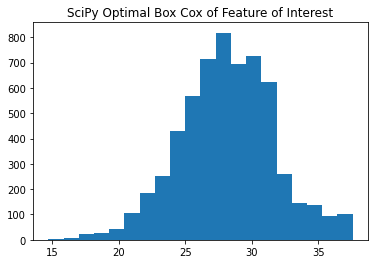

In [26]:
plt.hist(bc_fitted_feature, bins=20)
plt.title('SciPy Optimal Box Cox of Feature of Interest')
plt.show()

Now, let's do the same thing but with Yeo-Johson. We can note that the optimal lambda is the same along with the output. Due to its simplicity, it is better to use Box Cox unless you have data which does not have strictly positive values.

In [27]:
yj_fitted_feature, yj_fitted_lambda = stats.yeojohnson(feature)

yj_fitted_lambda

0.1910714444440362

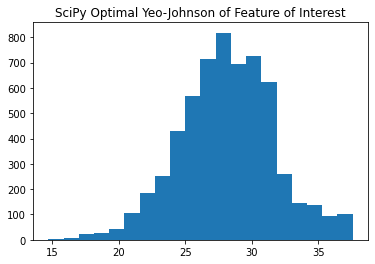

In [28]:
plt.hist(yj_fitted_feature, bins=20)
plt.title('SciPy Optimal Yeo-Johnson of Feature of Interest')
plt.show()

Lastly, let's do the normal test one last time with the optimal lambda found by `scipy`. We can see that the test statistic does not exceed the desired 0.05 but is much better than what we were dealing with previously.

In [29]:
stats.normaltest(yj_fitted_feature)

NormaltestResult(statistic=10.847274655668734, pvalue=0.004411072914542767)

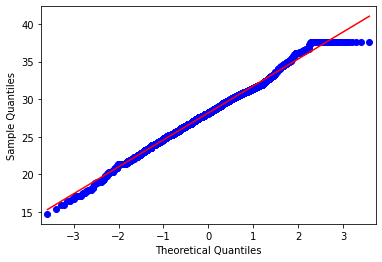

In [30]:
qqplot(yj_fitted_feature, line='s')
plt.show()

## Apply transformations on train and test data separately
So, before we continue let's quickly just apply a simple transform to all of our variables. We will just standardize them for now. Remember that you should be doing any transformations separately to your train data and test data. You want to try to keep your test data as pure as possible. If you make transformations before, you risk not having a truly representative sample of new unseen data to test your model on. To see this, recall that scaling involves computing statistics like the mean, standard deviatio or min/max. It makes a difference whether you compute these statistics only from the training data or from the combination of the training and test date. Thus, first scaline the data and then splitting it into training and test is a bad idea. The scaler classes in `sklearn` are designed in a way to help you avoid this flaw. 

In [31]:
numeric_cols = ["LOAN", "MORTDUE", "VALUE", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO", "DEBTINC"]

standard = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = standard.fit_transform(X_train_scaled[numeric_cols])

X_test_scaled[numeric_cols] = standard.transform(X_test_scaled[numeric_cols])

X_test_scaled.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero
4123,0.304857,0.566364,0.856570,DebtCon,ProfExe,1.802554,1.004812,-0.372598,-0.120033,-0.754040,0.388474,0.858198,False
2670,-0.303811,-1.642957,-0.100011,HomeImp,Other,0.576518,-0.274137,0.538452,1.125639,-0.754040,0.083394,-0.727901,True
3551,0.034338,-0.056216,0.087580,DebtCon,Office,0.167840,-0.274137,-0.372598,0.390757,0.572870,-0.831848,-0.058846,True
360,-1.173337,0.088693,-0.209736,HomeImp,Other,2.075006,-0.274137,-0.372598,1.802748,-0.754040,2.625732,-0.861204,True
152,-1.289273,-1.051946,-1.054833,HomeImp,ProfExe,0.440292,-0.274137,-0.372598,-0.079436,-0.090585,-0.119993,0.134477,True


In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 3442 to 3772
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LOAN       4768 non-null   float64
 1   MORTDUE    4768 non-null   float64
 2   VALUE      4768 non-null   float64
 3   REASON     4768 non-null   object 
 4   JOB        4768 non-null   object 
 5   YOJ        4768 non-null   float64
 6   DEROG      4768 non-null   float64
 7   DELINQ     4768 non-null   float64
 8   CLAGE      4768 non-null   float64
 9   NINQ       4768 non-null   float64
 10  CLNO       4768 non-null   float64
 11  DEBTINC    4768 non-null   float64
 12  DEROGzero  4768 non-null   bool   
dtypes: bool(1), float64(10), object(2)
memory usage: 488.9+ KB


## Encoding nominal features using weight-of-evidence coding

Weight of evidence encoding or WoE can be used to check if a variable has predictive power and can replace categories with that predictive power. Let's say we are computing a binary classification problem and we want to use this method to encode a categorical variable. We would first take the percent chance of y=0 (Good) and y=1 (Bad) for each category. Bad and good are often used because WoE comes from the credit scoring industry. We will then divide these two percents and take their natural logarithm. This is the WoE for that particular category, represented mathematically below:

$$ WOE_{cat} = ln\bigg(\frac{\text{% Good}}{\text{% Bad}}\bigg) $$


As you can see from this equation, this is a simple way to represent which categories contain the most cases of y=0 or y=1. This is then assumed to be the predictive power of the variable.

Note that you could apply the WoE transformtion also to a continuous variable after binning that variable. For example, if you had income as a continuous variable, you can determine cut-offs for "low earners", "medium earners" and "high earners" or whatever split makes most sense for your case. You could also use an algorithm find the best split for you (we introduce one below).

When you do your regression, you will now replace each bin or category with its respective WoE and perform the regression. The benefits of this include the ability to combine bins with similar WoE values and create more monotonic relationships which are easy to model. The drawbacks are possible loss of information and lack of ability to find correlation between variables.

### Information Value
After calculating WoE, we can calculate information value (IV) for a feature. This value will help us understand if the variable is useful in our prediction at all. It is calculated by finding the difference in the chance $y=1$ and $y=0$ multiplied by the WoE for each category, then summing all of these values for categories together.
 
$$ IV = \sum_{cat} \bigg( \big( p(\text{BAD})_{cat} - p(\text{GOOD})_{cat} \big) * \text{WOE}_{cat} \bigg) $$

### Adjusted Weight of Evidence
There is also an alternative way to calculate WoE and handle missing WoE, this is called Adjusted Weight of Evidence:

$$ ln \bigg(\frac{\text{number of non-events}+0.5}{\text{number of events}} \div \frac{\text{number of events} + 0.5}{\text{number of events}} \bigg) $$


### WOE from scratch

Of course, there are pre-made functions that we can use to calculate WoE. However, as usual, we will first code WoE from scratch so you can verify its inner mechanics. Let's first examine the counts of each of the possible categories of `JOB`.

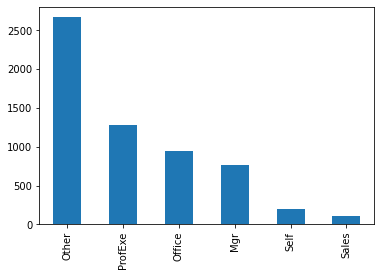

In [33]:
df['JOB'].value_counts().plot(kind='bar');

#### Object Creation
Instead of creating multiple functions and putting them together as we have done in the past, we are instead going to do something that is much more common in Python. We will create a new class and new methods/attributes. Note that each class starts with `class` then a name. You will then have to use `__init__` by convention to describe the initial arguments for the class. Note that `self` is always the first argument of everything in a class. This means that the originally set arguments will always be referenced after the object's initial creation. We recommend trying to create an object on your own to gain a much better understanding of how classes, methods and attributes work.

In [34]:
class IV_Calc:
    def __init__(self, df, feature, target):
        self.feature = feature
        self.target = target
        self.data_head = df.head()

    def count_values(self):
        data = pd.DataFrame()
        data['Count'] = df[self.feature].value_counts()               # Count instances of each category, create row for each
        data['Bad'] = df.groupby([self.feature])[self.target].sum()   # Count y=1 instances of that category
        data['Good'] = data['Count'] - data['Bad']                    # Count y=0 instances of that category
        data = data.sort_values(by=["Count"], ascending=False)
    
        try:
            assert data["Bad"].sum() != 0                               # Check that there are y=1 instances in sample
            assert data["Good"].sum() != 0                              # Check that there are y=0 instances in sample
            assert np.isin(df[self.target].unique(), [0, 1]).all()      # Check that target includes only 0,1 or True,False
        except:
          print("Error: Target must include 2 binary classes.")
          raise                                                       # Stop running if one of the above conditions is not satisfied
    
        return data

    def distribution(self):
        data = self.count_values()
        data['Ratio Bad'] = data['Bad'] / data['Count']
        data['Ratio Good'] = data['Good'] / data['Count']
        data["Distribution Bad"] = data["Bad"] / data["Bad"].sum()    # Of all y=0 instances, what percentage are from each category?
        data["Distribution Good"] = data["Good"] / data["Good"].sum() # Of all y=1 instances, what percentage are from each category?
        data = data.sort_values(by=["Count"], ascending=False)
        return data.iloc[:,-2:]
  
    def woe(self):
        data = self.distribution()
        data['WOE'] = np.log(data["Distribution Good"] / data["Distribution Bad"])
        data.replace({"WOE": {np.inf: 0, -np.inf: 0}})  # If no instances are bad, this will replace values of infinity with 0
        data = data.sort_values(by=["WOE"], ascending=False)
        return data.iloc[:,-1]
  
    def woe_adj(self):
        data = self.count_values()
        data["WOE_adj"] = np.log( 
            ((data["Count"] - data["Bad"] + 0.5) / (data["Count"].sum() - data["Bad"].sum())) / 
            ((data["Bad"] + 0.5) / data["Bad"].sum())
            )
        data.replace({"WOE_adj": {np.inf: 0, -np.inf: 0}})
        data = data.sort_values(by=["Count"], ascending=False)
        return data.iloc[:,-1]
  
    def IV_per_cat(self):
        data = self.distribution()
        data['WOE'] = self.woe()
        data["IV"] = data["WOE"]*(data["Distribution Good"] - data["Distribution Bad"])
        data = data.sort_values(by=["IV"], ascending=False)
        return data.iloc[:,-1]
  
    def full_summary(self):
        data = self.count_values()
        data['Ratio Bad'] = data['Bad'] / data['Count']
        data['Ratio Good'] = data['Good'] / data['Count']
        data["Distribution Bad"] = data["Bad"] / data["Bad"].sum()
        data["Distribution Good"] = data["Good"] / data["Good"].sum()
        data['WOE'] = self.woe()
        data["WOE_adj"] = self.woe_adj()
        data["IV"] = self.IV_per_cat()
        data = data.sort_values(by=["Count"], ascending=False)
        return data

    def final_assessment(self):
        data = self.full_summary()
        iv = data["IV"].sum() # final IV value
        if iv < .02:
            print("The variable " + self.feature + " is not predictive with an IV of: {}".format(iv))
        elif iv < .1:
            print("The variable " + self.feature + " is weakly predictive with an IV of:{}".format(iv))
        elif iv < .3:
            print("The variable " + self.feature + " is moderately predictive with an IV of:{}".format(iv))
        else :
            print("The variable " + self.feature + " is highly predictive with an IV of: {}".format(iv))
        return iv

In [35]:
# Use the functionality of our WoE class for encoding the feature JOB
train_df = pd.concat([X_train_scaled, y_train], axis=1, join="inner")

woe_job = IV_Calc(train_df, feature="JOB", target="BAD")

woe_job.full_summary()

,Count,Bad,Good,Ratio Bad,Ratio Good,Distribution Bad,Distribution Good,WOE,WOE_adj,IV
Other,2667,577,2090,0.216348,0.783652,0.485282,0.438063,-0.102366,-0.102993,0.004834
ProfExe,1276,212,1064,0.166144,0.833856,0.178301,0.223014,0.223761,0.221875,0.010005
Office,948,125,823,0.131857,0.868143,0.105130,0.172501,0.495199,0.491814,0.033362
Mgr,767,179,588,0.233377,0.766623,0.150547,0.123245,-0.200102,-0.202042,0.005463
Self,193,58,135,0.300518,0.699482,0.048780,0.028296,-0.544612,-0.549498,0.011156
Sales,109,38,71,0.348624,0.651376,0.031960,0.014882,-0.764350,-0.770404,0.013054


In [36]:
iv_job = woe_job.final_assessment()

The variable JOB is weakly predictive with an IV of:0.07787316133784931


We can now plot the WoE for each category and see how they compare. Keep in mind that this variable is only weakly predictive for our scenario. We can check the WoE for each of the categories as well. At this point we should decide whether it is actually worth it to continue using it in our analysis. If we do, we can replace these categories with their respective WoE values.

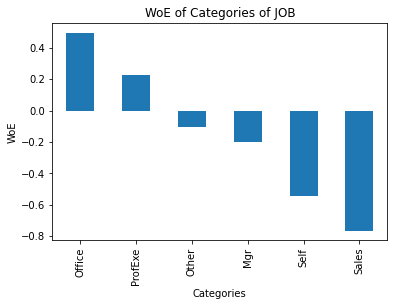

In [37]:
woe_job.woe().plot(kind="bar", title="WoE of Categories of JOB", ylabel="WoE", xlabel="Categories");

### WoE using `scorecardpy`

If you would like a quick implementation of the above, you can check out the package `scorecardpy`. You can view the documentation [here](https://pypi.org/project/scorecardpy/). If you enter a continuous variable as an argument, the function will automatically try to create bins that maximize the variable's usefulness as a WoE variable.

In [22]:
#!pip install scorecardpy
import scorecardpy as sc

Let's verify the functionality of the package by WoE coding a numerical variable. We pick `CLAGE` but you could use any.

[INFO] creating woe binning ...


{'CLAGE': <Figure size 432x288 with 2 Axes>}

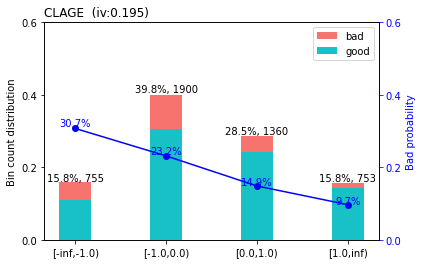

In [39]:
bins = sc.woebin(train_df, y="BAD", x='CLAGE')

sc.woebin_plot(bins)

Say you want to replace the numerical variable with its WoE representation. Here's a code snippet to do this.

In [40]:
sc.woebin_ply(train_df, bins) # if you would like to replace the variable with its WoE, you can do so using the woebin_ply function

[INFO] converting into woe values ...


,CLNO,DEROG,NINQ,DEBTINC,VALUE,DELINQ,MORTDUE,REASON,LOAN,DEROGzero,BAD,JOB,YOJ,CLAGE_woe
0,-1.238622,-0.274137,-0.090585,0.134477,-1.221219,-0.372598,-1.183333,HomeImp,-1.666068,True,True,Other,0.235953,0.582124
1,-0.730154,-0.274137,-0.754040,0.134477,-0.634123,1.449502,-0.053685,HomeImp,-1.646745,True,True,Other,-0.240839,0.195551
2,-1.136929,-0.274137,-0.090585,0.134477,-1.667411,-0.372598,-1.499275,HomeImp,-1.627422,True,True,Other,-0.649517,0.195551
3,-0.119993,-0.274137,-0.090585,0.134477,-0.217700,-0.372598,-0.182363,IsMissing,-1.627422,True,True,Other,-0.240839,0.195551
4,-0.730154,-0.274137,-0.754040,0.134477,0.237276,-0.372598,0.655575,HomeImp,-1.608099,True,False,Office,-0.785743,0.582124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,-0.628461,-0.274137,-0.754040,0.134477,-0.135047,0.538452,-0.593906,DebtCon,4.014832,True,False,Other,0.848971,-0.351214
5955,-0.526767,-0.274137,-0.754040,0.331714,-0.198723,-0.372598,-0.380594,DebtCon,4.014832,True,False,Other,0.985197,-0.351214
5956,-0.628461,-0.274137,-0.754040,0.293248,-0.143721,-0.372598,-0.449303,DebtCon,4.014832,True,False,Other,0.985197,-0.351214
5958,-0.526767,-0.274137,-0.754040,0.061717,-0.165226,-0.372598,-0.556816,DebtCon,4.014832,True,False,Other,0.712745,-0.351214


### Checking model performance: WoE vs. Dummies

Let's now try to perform a logistic regression using a one-hot encoded version of the dataframe and a version using WoE. first let's start with one-hot encoding and see how the model performs.

In [41]:
train_len = len(X_train)

X_full = pd.concat(objs=[X_train_scaled, X_test_scaled], axis=0)
X_full = pd.get_dummies(X_full, columns = ['REASON', 'JOB'], drop_first=True)

X_train_dummies = X_full[:train_len]
X_test_dummies = X_full[train_len:]

X_train_dummies.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
3442,-0.013969,-0.575144,1.178148,1.530102,-0.274137,-0.372598,0.643503,-0.754040,0.591862,-2.060643,True,0,0,0,0,1,0,0
5591,1.783050,1.373704,1.440128,0.304066,-0.274137,0.538452,0.434169,-0.090585,1.202023,1.510668,True,0,0,1,0,0,0,0
3037,-0.178213,-1.619543,1.276560,1.938780,-0.274137,-0.372598,-1.291740,0.572870,-0.018300,0.134477,True,1,0,0,0,0,0,0
2099,-0.497039,0.242856,0.283904,-0.513291,-0.274137,-0.372598,-1.019204,-0.090585,-0.831848,-0.029353,True,0,0,0,1,0,0,0
3838,0.169597,-1.416072,-1.413346,-0.785743,1.004812,-0.372598,-1.466199,0.572870,-0.018300,3.687849,False,1,0,0,1,0,0,0


In [42]:
print('The data set has {} features'.format(X_train_dummies.shape[1]))

The data set has 18 features


In [43]:
import statsmodels.api as sm 
X_train_dummies = sm.add_constant(X_train_dummies)

log_reg_dummies = sm.Logit(y_train.values.reshape(-1,1), X_train_dummies.astype(float)).fit() 
print(log_reg_dummies.summary())

Optimization terminated successfully.
         Current function value: 0.381238
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4768
Model:                          Logit   Df Residuals:                     4749
Method:                           MLE   Df Model:                           18
Date:                Fri, 15 Jan 2021   Pseudo R-squ.:                  0.2352
Time:                        15:04:35   Log-Likelihood:                -1817.7
converged:                       True   LL-Null:                       -2376.7
Covariance Type:            nonrobust   LLR p-value:                4.084e-226
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.4825      0.195     -7.605      0.000      -1.865      -1.100
LOAN       

In [44]:
from sklearn.metrics import roc_auc_score
X_test_dummies = sm.add_constant(X_test_dummies)

y_pred = log_reg_dummies.predict(X_test_dummies.astype(float))
roc_auc_score(y_test, y_pred)

0.8029317094388864

That did pretty well! Let's try to use WoE binning and see what kind of performance we get.

In [45]:
# Create bins for our two categorical variables

bins_regression = sc.woebin(train_df, y="BAD", x=['JOB', 'REASON'])

[INFO] creating woe binning ...


In [46]:
X_train_woe = sc.woebin_ply(X_train_scaled, bins_regression)

X_test_woe = sc.woebin_ply(X_test_scaled, bins_regression)

X_train_woe.head()

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,CLNO,DEROG,NINQ,DEBTINC,CLAGE,VALUE,DELINQ,MORTDUE,LOAN,DEROGzero,YOJ,REASON_woe,JOB_woe
0,-1.238622,-0.274137,-0.090585,0.134477,-1.063966,-1.221219,-0.372598,-1.183333,-1.666068,True,0.235953,0.156274,0.126725
1,-0.730154,-0.274137,-0.754040,0.134477,-0.722098,-0.634123,1.449502,-0.053685,-1.646745,True,-0.240839,0.156274,0.126725
2,-1.136929,-0.274137,-0.090585,0.134477,-0.378156,-1.667411,-0.372598,-1.499275,-1.627422,True,-0.649517,0.156274,0.126725
3,-0.119993,-0.274137,-0.090585,0.134477,-0.079436,-0.217700,-0.372598,-0.182363,-1.627422,True,-0.240839,-0.070269,0.126725
4,-0.730154,-0.274137,-0.754040,0.134477,-1.076828,0.237276,-0.372598,0.655575,-1.608099,True,-0.785743,0.156274,-0.517190


In [47]:
# Illustrate how WoE coding avoids an increase of dimensionality
print('The data set has {} features'.format(X_train_woe.shape[1]))

The data set has 13 features


In [48]:
log_reg_woe = sm.Logit(y_train.sort_index(), X_train_woe.astype(float)).fit() 
print(log_reg_woe.summary())

Optimization terminated successfully.
         Current function value: 0.391752
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 4768
Model:                          Logit   Df Residuals:                     4755
Method:                           MLE   Df Model:                           12
Date:                Fri, 15 Jan 2021   Pseudo R-squ.:                  0.2141
Time:                        15:04:36   Log-Likelihood:                -1867.9
converged:                       True   LL-Null:                       -2376.7
Covariance Type:            nonrobust   LLR p-value:                2.878e-210
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CLNO          -0.1624      0.048     -3.399      0.001      -0.256      -0.069
DEROG         -0.0246      0.

In [49]:
y_pred = log_reg_woe.predict(X_test_woe.astype(float))
roc_auc_score(y_test.sort_index(), y_pred)

0.7975772074815137

As we can see, in this case WoE does not help our model performance according to AUC. However, we do see significance for both WoE variables, unlike many categories of our dummy variables. As such, WoE can be more appropriate once the number of dummy variables could start to get very high. This high dimensionality could be a large concern for overfitting.

# Feature Selection

## Filter methods
Filters are statistical methods which test variables one by one and their relevance to the task at hand. Since they are relatively easy to compute, they tend to be checked first. The next methods of feature selection require more computational power, therefore eliminating variables using filters first will save time later.

Let's recall the chart we saw in class. The columns represent the target, is it continuous or discrete? The rows represent the variable to test, is it continuous or discrete/categorical? The best test is the one that corresponds to the right row/column.

```
Data Types      | CONTINUOUS TARGET     | DISCRETE TARGET
-------------------------------------------------------------------------------
CONTINUOUS VAR  | Pearson Correlation   | Fisher Score
CATEGORICAL VAR | Fisher Score / ANOVA  | Chi-Square / Cramer's V/ IV/ Gain
```



### Pearson Correlation
This is probably the most common correlation metric used. It is remarkable for its very simple implementation (covariance divided by the root of the product of each variance):

$$ \rho = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2 \sum_{i=1}^{n} (y_i - \overline{y})^2}} $$

This correlation is best used when target and the (independent) variable to check are **both continuous**. The coefficient produced is bound between -1 and 1. It is recommended to only keep variables with a high correlation, however there is no rule that you can always follow. The closer that this coefficient is to 0, the less correlation between the variable and the target.



### Fisher Score
This method of finding correlation can be used if **either** the target or variable in question is binary. It generalizes into an ANOVA test if there are multiple categories.

$$ FS = \frac{|\bar{x}_G - \bar{x}_B |}{\sqrt{s^2_G + s^2_B}} $$

### Analysis of Variance (ANOVA)
ANOVA specifically compares the means of a **feature with more than 2 categories with a continuous target**. For example, we had the feature `JOB`. If our target was continuous, ANOVA would be testing if each category in `JOB` actually corresponded to a different mean in our target. 

So, we first find the sum of squares between categories:
$$ SSD_B = \sum_{i=1}^k \sum_{j=1}^n \left(\bar{x}_i - \bar{x}_.\right)^2 = n\sum_{i=1}^k \left(\bar{x}_i - \bar{x}_.\right)^2 $$

We then find the sum of square difference within categories:
$$ SSD_W = \sum_{i=1}^k\sum_{j=1}^n \left(x_{ij} - \bar{x}_i \right)^2 $$

Now we divide the $ SSD_B $ by its degree of freedom: k categories minus 1. This gives us the mean $ SSD_B $. And then we divide $ SSD_W $ by its degrees of freedom, number of observations minus k categories. This gives us the mean $ SSD_W $.

$$ \mu_B = \frac{SSD_B}{k-1} $$

$$ \mu_W = \frac{SSD_W}{n-k} $$

Now we have the F-stastic that we can use.
$$ F = \frac{\mu_B}{\mu_W} $$

We must compare this value to the [F-Distribution Table](http://www.socr.ucla.edu/Applets.dir/F_Table.html) and decide whether we want to include it in the analysis.



### Chi-Square Analysis

Chi Square tests check whether events are dependent on one another. If there is no dependence between the target and the feature, it becomes less likely that it would actually would be meaninigful to include in the analysis.

$$ \chi^2 = \sum{\frac{(O_i - E_i)^2}{E_i}} $$

Chi square is only used when **both the feature of interest and the target are both categorical variables**. You must use a [chi-square table](https://web.ma.utexas.edu/users/davis/375/popecol/tables/chisq.html) (this one is alpha = 0.10) to assess whether you would like to include this varible in the end or not. Remember that if one category has too little observations, this test's results may not be accurate.

### Cramer's V

This method is always bound between 0 and 1. Higher values are more predictive with a threshold of 0.1 being the most common.

$$ V = \sqrt{\frac{\chi^2}{n}} $$

Cramer's V is based on Chi-Square, which means **both the feature of interest and the target are categorical variables**. This value is always bound between 0 and 1. A higher value indicates higher preditive power. A threshold of 0.1 is common.




### Information Value

This is the value that we calculated before in the section on Weight of Evidence. The main purpose of this value was to assess the preditive power of a **categorical variable and a binary target**. 

$$ IV = \sum_{cat} \bigg( \big( p(\text{BAD})_{cat} - p(\text{GOOD})_{cat} \big) * \text{WOE}_{cat} \bigg) $$

Generally, the following rule of thumb tells you the usefulness of a variable:

IV < 0.02: not predictive

0.02 – 0.1: weak predictive ability

0.1 – 0.3: medium predictive ability

0.3 < IV: strong predictive ability



### Information Gain / Entropy

Entropy normally means chaos. In machine learning, it is defined as an equal chance of selecting any category of the target variable. If you have a set of observations and there is an equal mix of all target labels in this set, entropy is maximized. If you can find some feature split to cause only one target label in each section of data, then entropy is minimized. Information Gain is the difference between the entropy before and the sum of entropy in each group after a split. As such, this method is most appropriate for **both a discrete feature and discrete target**.

Entropy is calculated by the following formula:

$$ E = -\sum^C_i p_i \cdot log_2(p_i) $$

Then information gain can be defined as the sum of entropy in total minus entropy of each category separately (this is the same as entropy in a decision tree):

$$ \text{Info Gain} = E_\text{total} - \sum{E_\text{category}}  $$

It is up to you to decide how little information gain to tolerate to consider a variable to be helpful.

Now that we know some of these methods, let's see what they look like in some code from scratch. Note that the function below is not made to deal with every type of data (especially if the target is a variable with multiple categories). However, we can see quite a lot of the decisions that you will need to make behind the scenes for it to all work.

In [50]:
class filter_binary_target:
    def __init__(self, df, target):
        self.target = target
        self.data_head = df.head()

    def auto_filter_binary_target(self):
        print('Data must be in a clean pandas DataFrame. Categorical variables must be of data type bool or category. Continuous variables must be int64 or float64.')
        data_no_target = df.drop(columns=self.target)
        columns = ['Data Type', 'Metric', 'Score']
        index = data_no_target.columns
        result = pd.DataFrame(index=index, columns=columns)

        for col in data_no_target:
            if data_no_target.dtypes[col] == 'bool' or data_no_target.dtypes[col].name == 'category':
                result.loc[col, 'Data Type'] = "discrete"
                result.loc[col, 'Metric'] = "IV"
                result.loc[col, 'Score'] = self.IV_binary_target(feature=col)

            if data_no_target.dtypes[col] == 'int64' or data_no_target.dtypes[col] == 'float64':
                result.loc[col, 'Data Type'] = "continuous"
                result.loc[col, 'Metric'] = "Fisher"
                result.loc[col, 'Score'] = self.fisher_binary_target(feature=col)

        return result

    def IV_binary_target(self, feature):  # same code as used above
        data = pd.DataFrame()
    
        data['Count'] = df[feature].value_counts()
        data['Bad'] = df.groupby([feature])[self.target].sum()
        data['Good'] = data['Count'] - data['Bad']
    
        data["Distribution Bad"] = data["Bad"] / data["Bad"].sum()
        data["Distribution Good"] = data["Good"] / data["Good"].sum()
    
        data['WOE'] = np.log(data["Distribution Good"] / data["Distribution Bad"])
        data.replace({"WOE": {np.inf: 0, -np.inf: 0}})

        data["IV"] = data["WOE"] * (data["Distribution Good"] - data["Distribution Bad"])

        iv = data["IV"].sum()

        return iv

    def fisher_binary_target(self, feature):
        mu_0 = df.groupby(df[self.target])[feature].mean()[0]
        mu_1 = df.groupby(df[self.target])[feature].mean()[1]
        var_0 = df.groupby(df[self.target])[feature].var()[0]
        var_1 = df.groupby(df[self.target])[feature].var()[1]

        num = abs(mu_0 - mu_1)
        den = (var_0 + var_1) ** 0.5
        score = num/den
    
        return score

    def pearson(self, feature):  # since our target is binary, we actually don't need this. However, if you would like to expand this class, you can use this code
        mean_feature = df[feature].mean()
        mean_target = df[self.target].mean()
        num = ((df[feature] - mean_feature)*(df[self.target] - mean_target)).sum()
        den = (((df[feature] - mean_feature)**2).sum() * ((df[self.target] - mean_target)**2).sum()) ** .5
        rho = num/den
        return rho

In [51]:
filter = filter_binary_target(df=train_df, target="BAD")

filter.auto_filter_binary_target()

Data must be in a clean pandas DataFrame. Categorical variables must be of data type bool or category. Continuous variables must be int64 or float64.


,Data Type,Metric,Score
LOAN,continuous,Fisher,0.13309
MORTDUE,continuous,Fisher,0.0951093
VALUE,continuous,Fisher,0.106516
REASON,discrete,IV,0.00861846
JOB,discrete,IV,0.0778732
YOJ,continuous,Fisher,0.0979491
DEROG,continuous,Fisher,0.358356
DELINQ,continuous,Fisher,0.473846
CLAGE,continuous,Fisher,0.324169
NINQ,continuous,Fisher,0.275753


So let's analyze this output. We cannot directly compare IV and Fisher scores but we can judge them relative to other variables calculated with the same score. We can see that of our 3 variables tested with IV, `REASON` is particularly weak and does not pass the 0.02 value threshold for IV. Therefore, we should eliminate it from the analysis. We can also see that of the variables for which we calculated a Fisher score, `CLNO`, `MORTDUE` and `YOJ` are all quite low.

At this point we could choose to eliminate these variables. However, let's leave them in for a little check using wrapper methods. 

## Wrappers
Unlike filter methods, which check one variable at a time with a statistical framework, wrappers try to iteratively build models in different ways to detect variables thatimpact a model's performance the most. As you can imagine, there are two major ways of doing this.
1. You add variables one at a time
2. You remove variables one at a time

Each time, you are double checking how the model performs with the inclusion or exclusion of a certain variable.

In [52]:
# Let's first set the one-hot encoded version of the dataframe as the default
X_train = X_train_dummies
X_test = X_test_dummies

In [53]:
from sklearn.linear_model import LogisticRegression # We will use sklearn here as it is required in the next algorithms

clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train,  np.ravel(y_train.values))
y_pred = clf.predict(X_test)
roc_auc_score(y_test, y_pred) # Note this value is different from the statsmodels value we found before for the same model earlier

0.634919530230535

### Stepwise regression (forward regression)
We will start with the first wrapper method described above. We can easily create this with a for-loop, but we will spare you the complexities by using `mlxtend` to sequentially add our possible features to the model using the function `SequentialFeatureSelector`. The machine will add variables one at a time and double check the model's performance. Note that a `sklearn` model is required as input to this function.

Note that unfortunately `sklearn` does not yet support stepwise regression on its own. However, if you'd like, there are ways to code it yourself through a loop that tries to find the best combination of variables through iterative model building like the [second answer to this StackExchange question](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm).

Let's use the algorithm from `mlextend` and check whether it corresponds to the features that our filter model also chose. In case you run this code on your own machine, you might have to [install the `mlextend` package first](https://anaconda.org/conda-forge/mlxtend).



In [54]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

clf = LogisticRegression(random_state=888, max_iter=1000, tol=0.01)
sfs = SFS(clf, 
           k_features=(3,12), 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=3)

sfs = sfs.fit(X_train, np.ravel(y_train.values))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [55]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))

best combination (ACC: 0.846): ('const', 'LOAN', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'JOB_Office', 'JOB_ProfExe', 'JOB_Self')



We can see from this regression, some of the variables that were candidates for elimination according to our filter method were actually kept. This may be because there are some variable interaction which we cannot observe using filter methods. It would be up to the analyst to try all combinations and determine the one that works best for the data.

We can plot the percent correctly classified vs. the number of selected features to see the algorithm's findings.

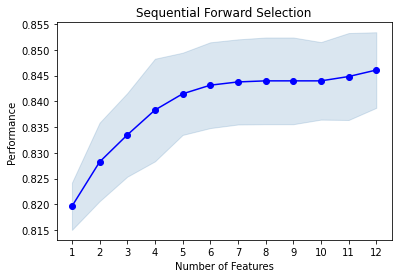

In [56]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection')

plt.show()

Lastly, let's check the AUC of the test set to see how this selection of features did on unseen data.



In [57]:
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

clf.fit(X_train_sfs, np.ravel(y_train.values))
y_pred = clf.predict(X_test_sfs)

In [58]:
roc_auc_score(y_test, y_pred)

0.6318399304045237

### Recursive feature elimination (backward selection)

Another extremely useful variable selection method is backward selection. We can actually implement it very easily using the `RFECV` function from `sklearn`. You can view the documentation for this function [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV). Let's see if it selects similar variables as our last wrapper model and the filter model.

In [59]:
from sklearn.feature_selection import RFECV
clf = LogisticRegression(random_state=888, max_iter=10000, tol=0.001)

rfecv = RFECV(estimator=clf, step=1, cv=2, scoring='accuracy')
X_train_new = rfecv.fit(X_train,  np.ravel(y_train.values))

print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 17


In [60]:
X_train.columns[rfecv.support_]

Index(['LOAN', 'MORTDUE', 'VALUE', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO',
       'DEBTINC', 'DEROGzero', 'REASON_HomeImp', 'REASON_IsMissing',
       'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self'],
      dtype='object')

In this regression, different variables were dropped and again they don't correspond to the candidates we found through our filter process. Again, this may be caused by some variable interaction, which we cannot observe by using filter methods. It is up to your discretion to experiment with combinations and determine the best course of action to solve your problem.

We can plot the percent correctly classified vs. the number of selected features to see the algorithm's findings.

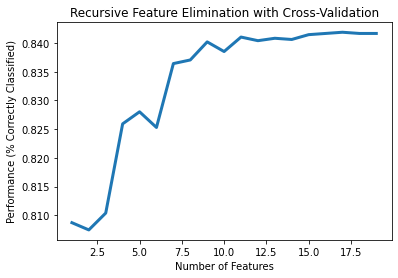

In [61]:
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of Features')
plt.ylabel('Performance (% Correctly Classified)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)

plt.show()

Lastly, let's check the mean error on the test set to see how this selection of features did on unseen data.

In [62]:
y_pred = rfecv.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6354458460200088

# Code organization
We are basically done with the material on feature engineering and feature selection. More generally, this notebook also marks an end to your journey through the space of data preparation. What you might have noticed is that code to prepare data can get rather long and hard to oversee. More generally, Jupyter notebooks can get really long, which makes them a bit more tedious to read. Does that sound familiar? <br> <br> Before concluding, we'd like to show you some 'tricks' to raise the readability of your notebooks and codes. The following two parts will briefly illustrate practices for structuring your codes across multiple files and introduce to **pipelines **. The latter are very useful to wrap-up chains of operations like different data preprocessing operations. 

## Importing from other scripts
Say you have already coded some functionality in another notebook and want to reuse it. Of course, you can copy and paste the corresponding code from your other notebook. This approach has many disadvantages. The biggest one might be that if you want to update your function, you would have to do so in two different notebooks; and will mostly forget to update one of the places leading to inconsistencies. A better approach is to move the function into a Python script file and to refer to it. It is crucial that this other file is indeed a **script file (i.e., a .py file) and note a notebook**. To our knowledge, you cannot refer to code in another notebook directly. It is also important to code the functionality that you want to reuse in a function.

To exemplify importing custom functions from .py files, we have created the file rf_test_auc.py. It contains a custom function that performs a train-test split on data, uses the training data to build a random forest and finally uses the test set to calculate the AUC. Using this other file, we can simply import the function that we want and run the function to get our results. That said, the following example requires that the **.py file with the function is available in your working directory**.  

In [63]:
from rf_test_auc import RF_test_AUC # this is easiest when the .py file is in your working directory

RF_test_AUC(X_train, y_train, X_test, y_test, n_estimators = 150)

0.9806546324488908

Now you can keep your notebooks nice and neat by leaving out some functions that you had to code yourself whose inner workings are not the most critical for your readers to see right away.

Note that you can use files which are not in your working directory, however this is a bit more complicated. You can find tutorials on how to do this using many tutorials online such as [this one](www.youtube.com/watch?v=A7E18apPQJs). 

## Pipelines

After we have decided how we would like our finalized data to look like in the end, we will likely have to repeat the modifications to our data set several times over (for the train set, test set, new batches of data etc...). In this case, it can be very useful to set up a pipeline which makes the same adjustments to raw data.

In [24]:
# Let's reload the raw data

#data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_prepared.csv' 
#df = pd.read_csv(data_url)
file = '/Users/aubrey/Documents/GitHub/BADs/data/hmeq_prepared.csv'
df = pd.read_csv(file)


# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [25]:
# Now let's use a pipeline to transform our data using some of what we have learned above

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# If you only want a transformation on select columns, it is good to first use ColumnTransformer
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [3, 4]), # ('step_name', fun(), list_cols) always follow this format for each step of the transfomer
                                              ('scl', StandardScaler(), [0, 1, 2, 5, 6, 7, 8, 9, 10])], # Note that below RF is used as a classifier, thus, scaling is not exactly necessary
                                              remainder='passthrough')

# Construct some pipelines
pipe = Pipeline([
                ('t', transformer), # ('step_name', transfomer) always follow this format for transformers in the pipeline
                ('clf', RandomForestClassifier()) # ('step_name', fun()) add parantheses for other functions
                ])

ImportError: cannot import name 'joblib' from 'sklearn.externals' (/Users/aubrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/externals/__init__.py)

This little bit of code wraps-up almost all of the preprocessing steps, which we discussed in this notebook. The code does look a little complicated but you will agree that it is concise. So the idea is that we chain operations together, such that the result of one operation (e.g., one-hot-coding of variables) are forwarded as input to a subsequent step. Above, we effectively code two chains, one chain of feature transformations and later one chain with two steps, all feature transformations together and learning a classifier. It is very easy to execute the chain of operations, i.e. the pipeline:

In [66]:
# Learning a RF classifier on the preprocessed data set with one line:
pipe.fit(X_train, y_train.values.ravel())

Pipeline(memory=None,
         steps=[('t',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  [3, 4]),
                                                 ('scl',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                

In [67]:
# Let's next get predictions and compute AUC of the learned RF classifier
y_pred = pipe.predict(X_test)
roc_auc_score(y_test, y_pred) # check AUC

0.8436741044323011

The example highlights that once the pipeline is set up, something that you could do in a custom function, which you the put into a .py file, you can run it with basically one line of code. These tools help you to focus your notebook to the most important aspects of your task. For example, the next tutorial will look into [model diagnosis and interpretation](https://github.com/Humboldt-WI/bads/blob/master/tutorials/10_nb_interpretale_ML.ipynb). You can grasp that we will first need a model before talking about interpreting that model. Using the command `pipe.fit(X_Train, y_train)` you can get such a model super easily, and focus your notebook on model interpretation. More generally, piplines help you to keep your code clean and comprehensible, and are, therefore, a useful thing to have on your list.

# Conclusion

The  demos above should have provided some ideas for useful transformations and feature selection. In the exercise questions, we will try to apply some of these techniques to the HMEQ dataset and see the effect they have on prediction values. Remember again there is no single way to apply these steps to all types of data. You'll have to experiment and find which combination works best for your problem. Happy coding!




# Overview table

| Goal | Possible Code |
| --- | --- |
| Get data types of each column | `df.dtypes` |
| Select all float columns of a df | `df.select_dtypes(include='float64')` |
| Create min-max scaling or normalization object | `MinMaxScaler()` |
| Create standardization object | `StandardScaler()` |
| Modify `X` with a Box Cox transformation (positive values only) | `stats.boxcox(X) ` |
| Modify `X` with a Yeo Johnson transformation | `stats.yeojohnson(X)` |
| Test if a variable is normally distributed (p-val > 0.05 points to normality) | `statsnormaltest(X)` |
| Create QQ plot for `X` (lines should correspond) | `qqplot(feature, line='s')` |
| Get WoE weights of `feature_i` | `scorecardpy.woebin(train_df, y="target", x='feature_i')` |
| Plot weights of `woebin` | `scorecardpy.woebin_plot(woebin_obj)` |
| Replace the feature calculated in `woebin` with its results| `scorecardpy.woebin_ply(X_train, woe)` |
| Pearson's coefficient | `stats.pearsonr(X, y)` |
| Calculate Chi2 value for X and y | `chi2(X, y)` |
| Get dummy values for `feature` with prefix `name_` | `pd.get_dummies(X.feature, prefix='name')` |
| Create forward variable selection object | `SequentialFeatureSelector()` |
| Returns `X` of only selected features | `sfs_model.transform(X_train)` |
| Create backward variable selection object | `RFECV()` |
| Use fitted RFECV model to predict on test set | `rfecv_model.predict(X_test)` |
| Create object which uses `fun` on cols in `col_list` and keeps unchanged columns | `ColumnTransformer(transformers=('step_name', fun(), list_cols), remainder='passthrough')` ** |
| Create pipeline object | `Pipeline(('step_name', fun))` ***|
| Pass X_train through pipeline for fitting | `pipe_name.fit(X_train, y_train)`|
| Pass X_test through pipeline for prediction | `pipe_name.fit(X_test)`|


** In `ColumnTransformer`, you can add a list of transformers of that format in the `transformer` argument

*** In `Pipeline`, you can add a list of steps of that format as the first argument. It is encouraged to put your classifier in here as the last step

# Exercises

## Power transformations 
- Box-Cox (BC) and Yeo-Johnson (YJ) transformation exhibit hyperparameter $\lambda$. Implement a custom function that receives a feature as input and grid-searches the best value of $\lambda$. The caller should be able to specify whether s/he wants to use BC or YJ. Your function can assess the merit of a value of $\lambda$ by means of the function `normaltest()`, the use of which we illustrated above. The more normal a feature after the transformation, the better the value of $\lambda$. 

- Write another custom function `best_transform()`. Given a DataFrame with input data, your function should identify the best power transformation for each numerical feature. Note that using the raw feature without transformation is also possible and might be the best approach. Also remember to tune $\lambda$ when needed using your solution to the previous exercise. Try out your function using the HMEQ data. Display the best transformation for each feature.

**Optional** 
- Till here, we have assessed the merit of a transformation by means of checking normality using `normaltest()`. Arguably, a better approach for predictive modeling would be to test if a model trained on the transformed data generates better predictions. To implement this logic, you need a custom function that implements our standard predictive modeling pipeline (see, e.g., Tutorial 5 or Tutorial 7) to estimates the predictive performance of a model, say logistic regression, on an input data set. Once you have this function, you can revise your solutions to the previous exercises such that they call the function just implemented instead of `normaltest()`. 
- Test your function using the HMEQ data set
- Perform a final test what approach gives better results (in terms of AUC on HMEQ) optimizing feature transformations using `normaltest()` or by assessing predictive accuracy. *For the experts, make sure to not overfit* 
---
## Weight of evidence coding (challenging)
A standard risk modeling workflow in banking is the following
- Discretize all numeric features in a data set
- Optimize categorical features by re-grouping/merging category levels
- WOE transform all categorical variables
- Build logistic regression-based scorecard

Your task is to implement this workflow. The previous demos provide much of the functionality that you need. However, some extensions are needed and you have to put everything together. To keep things manageable, let's agree on the following heuristic:
Implement step 1 and step 2 by fitting a shallow tree to the data (e.g., at most 5 leaf nodes). This will work with numerical and categorical features alike. The leaf nodes of your shallow tree represent the new, re-grouped, optimized categorical features. After this tree-based transformation, you can WOE-encoded the whole data set in one go.

Compare a logit model using your transformed data set to one from our standard version of the data [add link here]

## Feature selection
- We discussed that sklearn does not offer stepwise regression. Implement a stepwise logit using AIC from scratch. To that end, you will need to decide on a search direction (forward or backward) and scoring criterion. The latter is needed for selecting the next feature to be added to or deleted from a model. Understanding the role of the search criterion is a very good learning outcome in its own right. There is probably no single correct or best solution how to score candidate features. Try to come up with a sensible approach.  